# Create our very own image classification algorithm

Today we are going to have a look at how you can perform your own end to end image classification project. In many of your roles you may not think you have use cases for image classification, and that may be true however these are some examples of where it could be applied in an industry such as BP
- Satilitate images - oil spill detection
- Health and safety detection -  Is the person wearing a helmet or goggles?
- Enginnering component checks -  Automatically scan through pictures of equipment searching for cracks
- Satilite images for land use classification - If you are building a new pipeline based on your planned route can you estimate the cost based on the current land use?


I should note we are doing ***image classification** today. That is take an image and from the the pixel values in that image apply it to a category or class. There are more advanced image classification algroithms that look to segment every pixel in the image and applly that to a category

![classifciation](https://miro.medium.com/v2/resize:fit:1400/1*Hz6t-tokG1niaUfmcysusw.jpeg)


## Stages
1. Problem Statement
2. Collect images
3. Inspect images
4. Clean images
5. Use a CNN network to perform custom image classification
6. Evaluate results
7. Test on a new image

### What are you classifying? 

In this workshop we are going to attempt to make an algorithm that will classify cars from lorrys from vans all from scratch. This could be a use case for BP. Knowing the proportion of vehicles at a locaiton could inform business strategy for example. 

I will also share with you a script that allows you to create a classifier on a topic you are more interested in

## Generating your own Dataset
This section will be different to what we saw in the workshop since we took an already prepared dataset. In order to generate your dataset you will:
- Use a bing images api to collect images that belong to a certain search category
- Validate these images - check they are sensible
- Tranform these images- Force them to be the same dimensions
- Augment** these images to increase the size of our dataset

First lets install our packages

In [ ]:
# !pip install opencv-python
# !pip install imgaug
# !pip install bing_image_downloader

In [1]:
import keras
import tensorflow
import os
import random
from PIL import Image
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import cv2 
import json
import pandas as pd

import requests
from io import BytesIO

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf 

print(keras.__version__)
print(tensorflow.__version__)

2.6.0
2.6.0


### Getting images from bing 
Instructions
1. Install bing image downloader using pip
2. Run the cell below with your categories. This may take some time. You should see folders inside dataset populate with your data 

In [2]:
from bing_image_downloader import downloader
search_categories = ['macaws', 'rainbow_lorikeets', 'budgies']# e.g ['cats', 'dogs']
# search_categories = ['cats', 'dogs']
for search_string in search_categories:
    downloader.download(search_string, limit=100,  output_dir='dataset', force_replace=False, timeout=60, verbose=False)

[%] Downloading Images to C:\Users\PeterBaksh\OneDrive - Corndel Ltd\Documents\public_git_repo\image_processing\image_classifier\dataset\macaws
[!] Issue getting: https://trszone.com/wp-content/uploads/2020/09/Lears-macaw-4.jpg
[!] Error:: <urlopen error [Errno 11002] getaddrinfo failed>
[Error]Invalid image, not saving http://i.telegraph.co.uk/multimedia/archive/01846/macaw_1846932c.jpg

[!] Issue getting: http://i.telegraph.co.uk/multimedia/archive/01846/macaw_1846932c.jpg
[!] Error:: Invalid image, not saving http://i.telegraph.co.uk/multimedia/archive/01846/macaw_1846932c.jpg

[!] Issue getting: http://i250.photobucket.com/albums/gg276/tik_wangrug/Birds 2/Macaw.jpg
[!] Error:: URL can't contain control characters. '/albums/gg276/tik_wangrug/Birds 2/Macaw.jpg' (found at least ' ')
[Error]Invalid image, not saving http://hqdesktop.net/wallpapers/m/68/birds_animals_parrots_scarlet_macaws_macaw_m67748.jpg

[!] Issue getting: http://hqdesktop.net/wallpapers/m/68/birds_animals_parrots_sc

In [3]:
# Define folder path containing images
print('When Image opons press "y" to keep image, "q" to exit the process or any other key e.g "n" to remove the image from our images')

images_to_keep = {}
for category in search_categories:
    print('clasifing ', category)
    folder_path = os.path.join('dataset', category)
    
    image_files = os.listdir(folder_path)
    keystrokes = []
    for image_file in tqdm(image_files):
        # Open image file
        try:
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path)
            cv2.imshow('Image', image)
            key = cv2.waitKey(0)
            keystrokes.append(key)
            if key == ord('q'):
                breakq
        except:
            print('error in image load')
            keystrokes.append(200)
    cv2.destroyAllWindows()
    images_to_keep[category] = keystrokes
cv2.destroyAllWindows()

When Image opons press "y" to keep image, "q" to exit the process or any other key e.g "n" to remove the image from our images
clasifing  macaws


  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

error in image load


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [02:22<00:00,  1.41s/it]


clasifing  rainbow_lorikeets


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


clasifing  budgies


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:14<00:08,  1.18s/it]

error in image load


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


### Lets view the images we removed

Below we can just look over the images we manually removed

In [ ]:
## if you skipped the last step
# with open("images_to_keep.json") as f:
#     data = json.load(f)

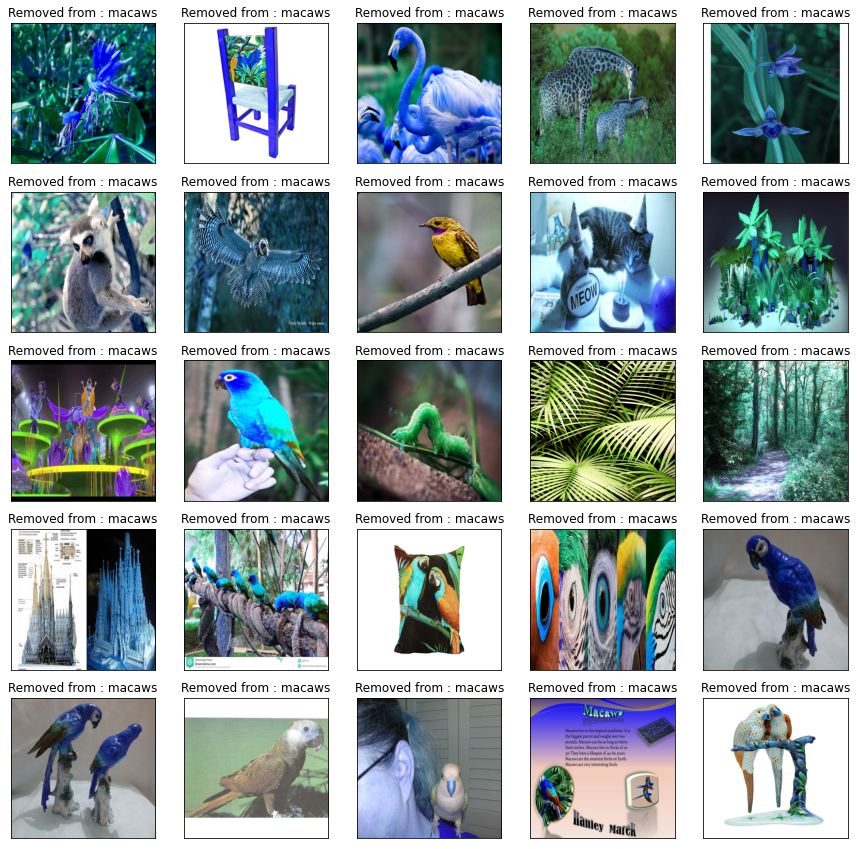

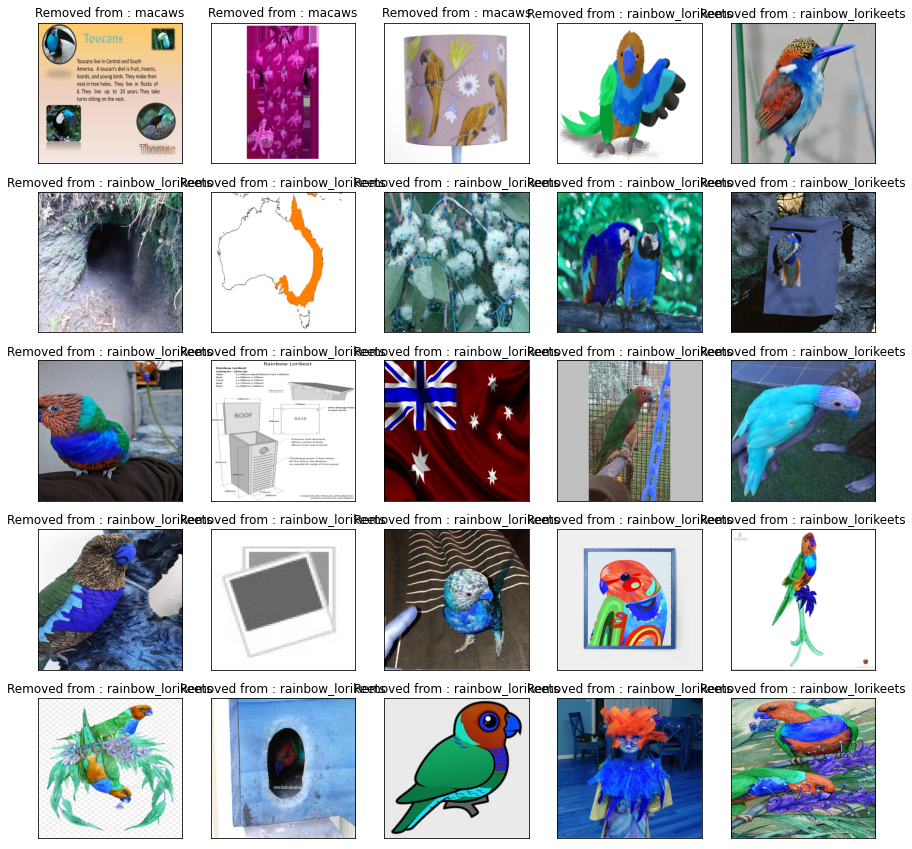

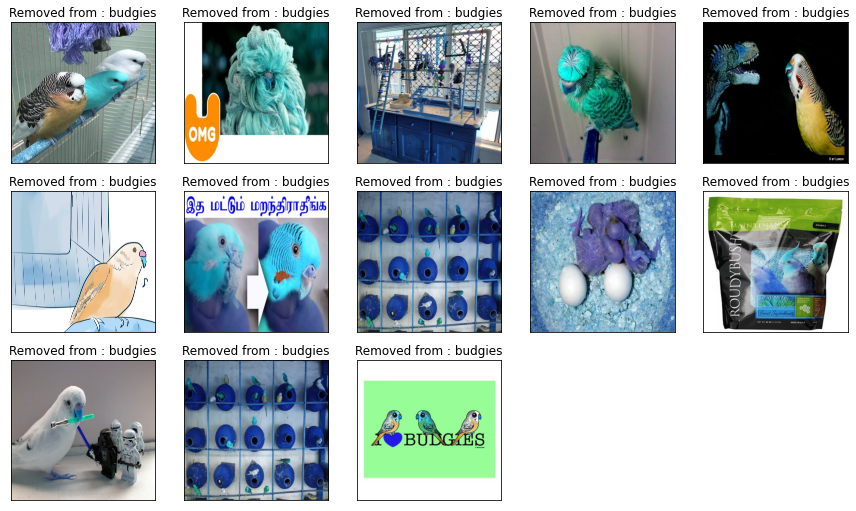

In [4]:

counter = 0
for category in search_categories:
    keystrokes = images_to_keep[category]
    folder_path = os.path.join('dataset', category)
    image_files = os.listdir(folder_path)
    im_index = 0
    for keystroke in keystrokes:
        if keystroke != 121:
            try:
                image_path = os.path.join(folder_path, image_files[im_index])
                image = cv2.imread(image_path)
                plt.subplot(5,5,counter +1)
                plt.imshow(image)
                plt.title('Removed from : ' + category)
                plt.axis('tight')
                plt.xticks([])
                plt.yticks([])
                counter +=1
                if counter == 25:
                    fig = plt.gcf()
                    fig.set_size_inches(15, 15)
                    plt.show()
                    counter = 0
            except:
                pass
        im_index+= 1
            
            
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()            
    

## Image Augmentation

Because we do not have a huge number of images in each class we are going to increase the number in each category using image augmentaiton
Image augmentaiton:

*Image augmentation refers to a set of techniques used to artificially increase the size of a dataset of images for machine learning or computer vision tasks. These techniques can be used to improve the performance of machine learning models by introducing variations of the original images, which can help the models to generalize better and reduce overfitting.*

*There are many types of image augmentation techniques, including:*

*Flipping or mirroring: the image is flipped horizontally or vertically*

*Rotation: the image is rotated by a certain angle*

*Scaling: the image is scaled up or down*

*Translation: the image is shifted horizontally or vertically*

*Cropping: a portion of the image is cropped out*

*Adding noise: random noise is added to the image*

*Changing brightness or contrast: the brightness or contrast of the image is modified*

*Changing color: the color of the image is modified*

By applying these techniques to the original images, we can generate many new images with variations that are still similar to the original images. These augmented images can be used to train machine learning models, which can then better recognize and classify new images in the future.

We can look at a quick example below





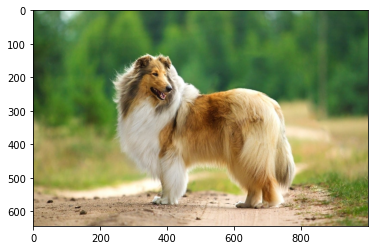

In [5]:
 ## Get the original image
url = "https://www.hepper.com/wp-content/uploads/2021/11/shutterstock_164646389.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

Make a dictionary of the augmentations 

In [6]:
import imgaug.augmenters as iaa
aug_seq = iaa.Sequential([
    iaa.Fliplr(0.5),        # flip horizontally with probability 0.5
    iaa.Affine(rotate=(-100, 100), scale=(0.8, 1.2)),   # rotate and scale
    iaa.GaussianBlur(sigma=(0, 0.2)),    # apply gaussian blur with sigma between 0 and 3.0
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))    # add gaussian noise
])

View the effect of the augmentations

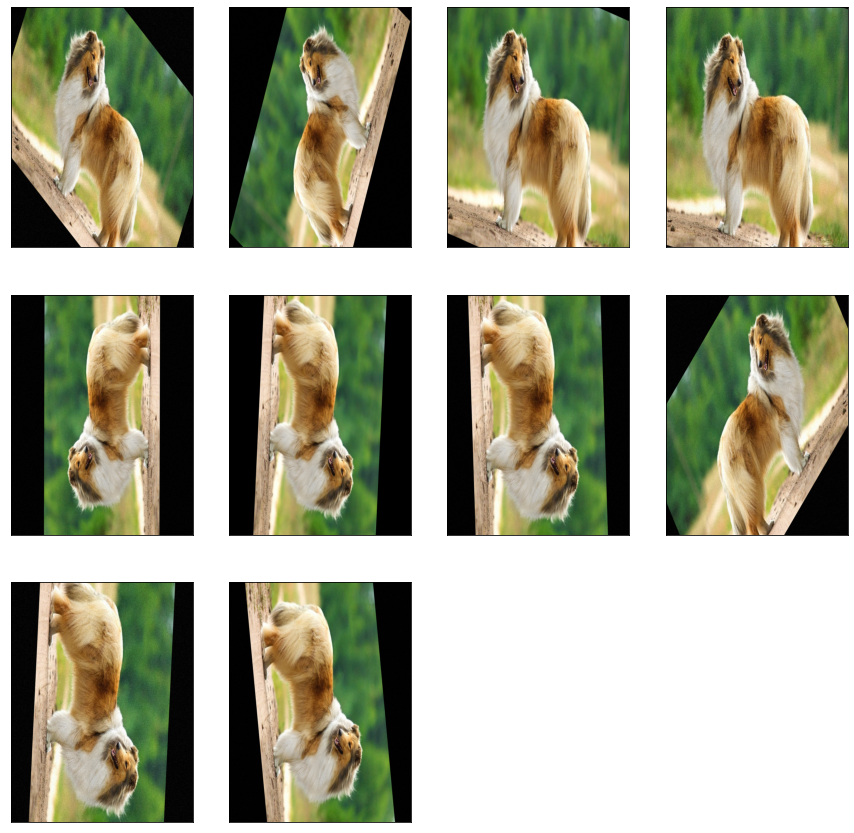

In [7]:
for i in range(10):
    aug_img = aug_seq.augment_image(np.array(img))
    plt.subplot(3, 4, i + 1)
    plt.imshow(aug_img)
    plt.axis('tight')
    plt.xticks([])
    plt.yticks([])

fig = plt.gcf()
fig.set_size_inches(15,15)

**Apply Augmentations on our data**

We shall now apply the augmentations to all of the images that we selected from our bing search

**Note**
We are going to use approximately the first 20 images for testing. We will make sure we do not apply augmentations to those. The rest of the images will be used for training and we can augment these

In [8]:
image_list_train = []
target_list_train = []

image_list_test = []
target_list_test = []

for category in search_categories:
    keystrokes = images_to_keep[category]
    folder_path = os.path.join('dataset', category)
    image_files = os.listdir(folder_path)
    im_index = 0
    for keystroke in tqdm(keystrokes):
        if keystroke == 121:
            if im_index < 20:
                image_path = os.path.join(folder_path, image_files[im_index])
                image = cv2.imread(image_path)
                resized_img = cv2.resize(image, (128, 128))
                image_list_test.append(resized_img)
                target_list_test.append(category)
            else:
                for i in range(10):
                    image_path = os.path.join(folder_path, image_files[im_index])
                    image = cv2.imread(image_path)
                    resized_img = cv2.resize(image, (128, 128))
                    aug_img = aug_seq.augment_image(resized_img)
                    image_list_train.append(aug_img)
                    target_list_train.append(category)
        im_index+= 1

            


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


Define X_train, X_test. y_train, y_test

In [9]:
X_train = np.array(image_list_train)
y_train = np.array(target_list_train)
X_test = np.array(image_list_test)
y_test = np.array(target_list_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1880, 128, 128, 3), (48, 128, 128, 3), (1880,), (48,))

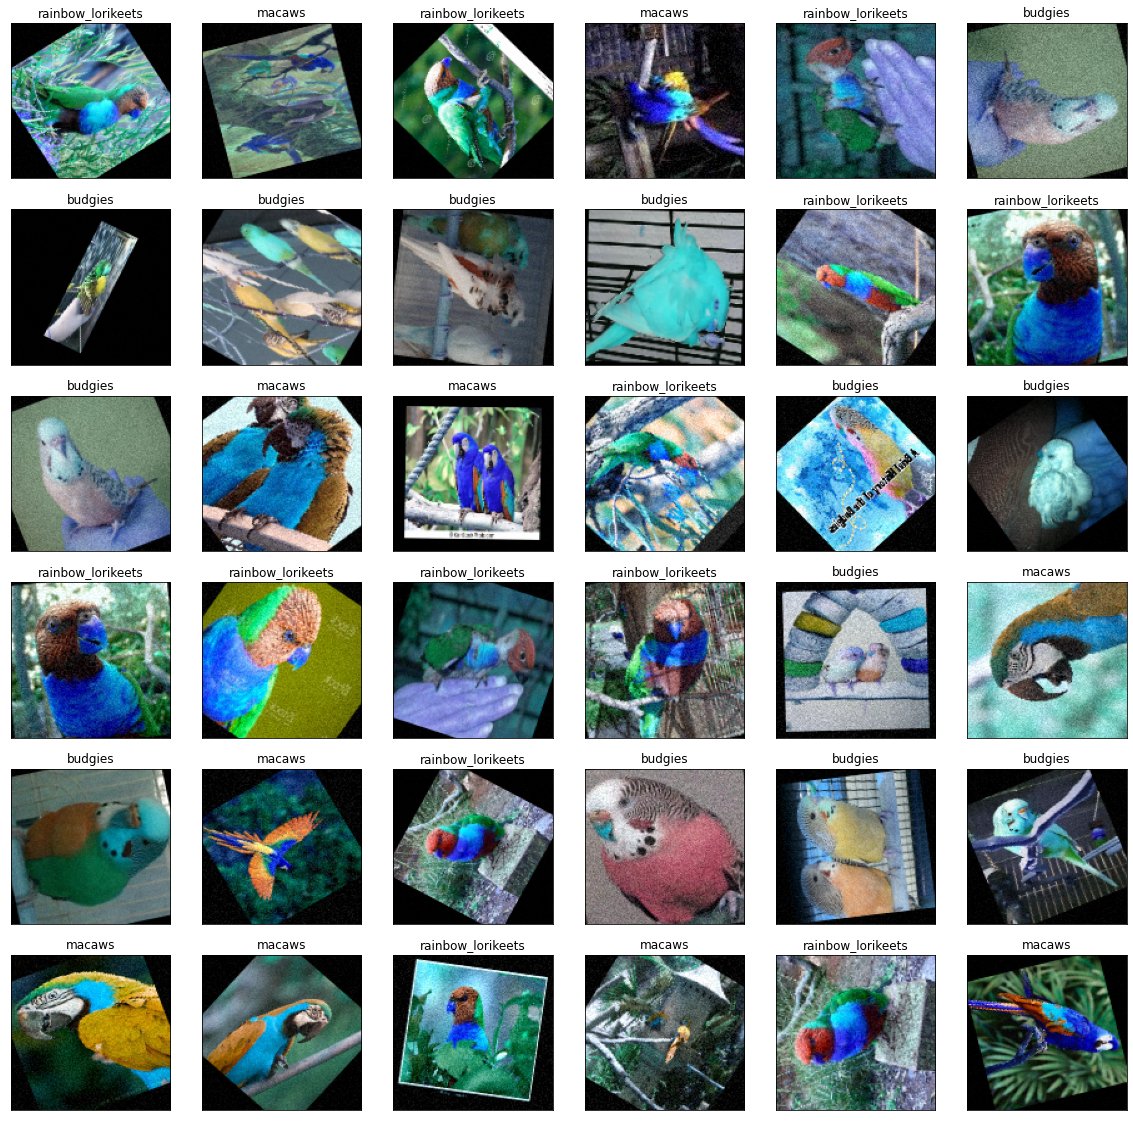

In [10]:
sample_images = 40
subplot_x, subplot_y = int(sample_images**0.5), int(sample_images**0.5)
image_num = 1
for i in range(int(subplot_x * subplot_y)):
    plt.subplot(subplot_x, subplot_y, image_num)
    num = random.randint(1, len(X_train))
    plt.imshow(X_train[num, :, :, :])
    plt.title(y_train[num])
    plt.axis('tight')
    plt.xticks([])
    plt.yticks([])
    image_num += 1

fig = plt.gcf()
fig.set_size_inches(20, 20)

In [11]:

class2label = dict(zip(search_categories, range(len(search_categories))))
label2class = dict(zip( range(len(search_categories)), search_categories))
y_train_encoded = pd.DataFrame(y_train).iloc[:, 0].map(class2label).values
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))

y_test_encoded = pd.DataFrame(y_test).iloc[:, 0].map(class2label).values
onehot_encoder = OneHotEncoder(sparse=False)
y_test_onehot = onehot_encoder.fit_transform(y_test_encoded.reshape(-1, 1))

## Manual check that the encoding looks correct
# for i in range(5):
#     r = random.randint(1, 1700)
#     plt.imshow(X_train[r, :, :, :])
#     plt.title(y_train_onehot[r])
#     plt.show()

# print('test data')
# for i in range(5):
#     r = random.randint(1, 40)
#     plt.imshow(X_test[r, :, :, :])
#     plt.title(y_test_onehot[r])
#     plt.show()

In [15]:
y_test.shape, y_test_onehot.shape
counter = 0
for i, j in zip(y_test, y_test_onehot):
    print(i, j)



macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
macaws [1. 0. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
rainbow_lorikeets [0. 1. 0.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.]
budgies [0. 0. 1.

In [16]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class AccuracyHistory(Callback):
    def __init__(self, plot_interval=3):
        super(AccuracyHistory, self).__init__()
        self.plot_interval = plot_interval
        self.accuracy = []
        self.val_accuracy = []

    def on_epoch_end(self, epoch, logs={}):
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        if epoch % self.plot_interval == 0:
            plt.plot(self.accuracy, label='Training Accuracy')
            plt.plot(self.val_accuracy, label='Validation Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

## Convolutional Neural Network with Transfer Learning!

This is advanced stuff we are using. I will do my best to explain as simply as possible

- Convolutional Neural Networks are models that attempt to learn the best spatial filters in order to design a network to meet their classificaiton task

- Imagine you have a childs toy with various shapes. You have an idea of the types of shapes you may get and you need to make physical filters in order to identify shapes in to circles stars arrows and rectangles. Using your prior knowledge you may start of by designing a first layer of filters as shown below. These filters separate out the stars and the cicles from the square rectangle and arrow. You then have to make a further layer of filters to filter the rest down to each object. You are using your past knowledge of standard shapes to design these filters to the problem. In a CNN these layers / filters are learnt from the data 

<img src = "https://raw.githubusercontent.com/DrPBaksh/workshop-data/main/cnn_diagram_1.PNG"  width="500" height="400">

CNN learn these best filters.

The standard type of digagram used to show a CNN arhitecutre is below

<img src = 'https://production-media.paperswithcode.com/method_collections/cnn.jpeg' width="500" height="400">

The image at the begining is input to the network. The shape of that input is the shape in pixels and colour dimensions of the image. It then goes through lots of complicated convilutional layerss before being connected up to an output that is the size of the number of categories that we are using



**Transfer Learning**

There are only a couple of points I want you to think about with transfer learning
- CNNs netorks work best when their weights (the strength of their connections) and the design of their filters has been trained on very large datasets 
- In image classification you can often use a network that has been pre trained on a huge amount of images to learn filters and connections and then you tweak the end of the network for your purpose
- Image teaching a baby how to classify dogs and cats. First the baby needs to learn how to understand images. It needs to learn that different things are different colours. It needs to learn that the same object can appear in different sizes etc. Once that baby has learnt more about images in general you can then get it to learn the difference between a cat and a dog through examples. In transfer learning we do not start from scratch. We start with a human who has already experience the world through their eyes. We now give them some pictures of dogs and cats and they are better placed to begin identifying them 


<img src = 'https://www.researchgate.net/profile/Mazin-Mohammed/publication/347946990/figure/fig3/AS:973645212049408@1609146516624/Example-of-transfer-learning-in-medical-images.png
' width="500" height="400">

Epoch 1/5
59/59 [==============================] - 28s 301ms/step - loss: 0.6643 - accuracy: 0.7495 - val_loss: 0.3394 - val_accuracy: 0.9167


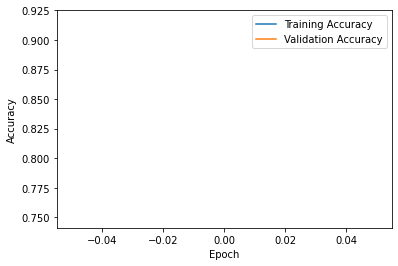

Epoch 2/5
59/59 [==============================] - 13s 226ms/step - loss: 0.3678 - accuracy: 0.8878 - val_loss: 0.1928 - val_accuracy: 0.9583
Epoch 3/5
59/59 [==============================] - 13s 222ms/step - loss: 0.2794 - accuracy: 0.9266 - val_loss: 0.1478 - val_accuracy: 0.9583
Epoch 4/5
59/59 [==============================] - 15s 259ms/step - loss: 0.2265 - accuracy: 0.9447 - val_loss: 0.1206 - val_accuracy: 0.9792


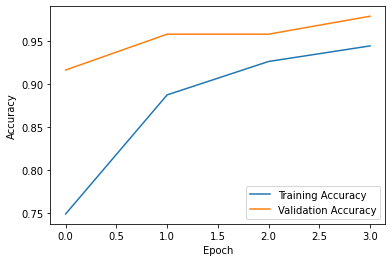

Epoch 5/5
59/59 [==============================] - 15s 258ms/step - loss: 0.1888 - accuracy: 0.9569 - val_loss: 0.0977 - val_accuracy: 1.0000


In [17]:
### Our neural network
# We take a pre trained model but say can we change the top layer for our image shape
base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
# We say we do not want to retrain anything in this network at the moment
base_model.trainable = False
# We tell the model that we are going to inpouting images of shape 128, 128 into the network
inputs = tf.keras.layers.Input(shape=(128, 128, 3), name="input_layer")
# Apply that inoput layer on the top of our pre trained model
x = base_model(inputs)
# We are going to add a layer onto the imported network that it can learn the specifics for the cat and dog
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# We are going to have an iput layer equal to the number of categories
outputs = tf.keras.layers.Dense(len(search_categories), activation="softmax", name="output_layer")(x)
# COmpile that model together
model = tf.keras.Model(inputs, outputs)
# Apply the settings for the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# fit the model to the data
history = model.fit(X_train, y_train_onehot, epochs=5, validation_data=(X_test, y_test_onehot), callbacks=[AccuracyHistory(plot_interval=3)])


## Evaluate the performance of the model

In [18]:
# evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test_onehot)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


2/2 [==============================] - 0s 155ms/step - loss: 0.0977 - accuracy: 1.0000
Test loss: 0.09767120331525803
Test accuracy: 1.0


Below we plot the results from our testing data and view the networks classificaiton on our images

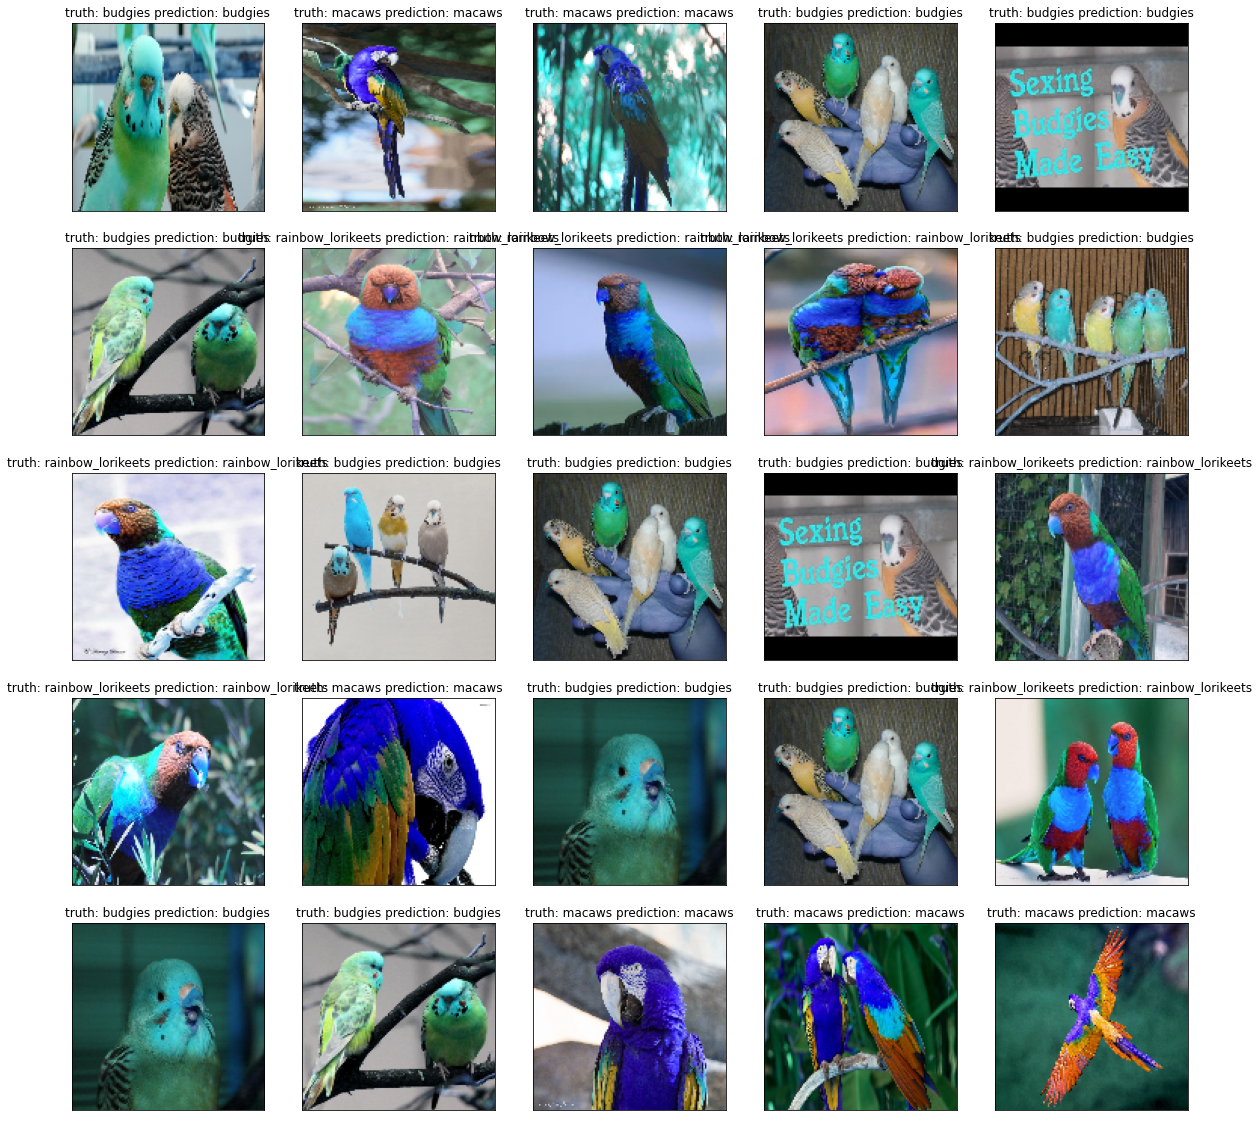

In [19]:
sample_images = 30
subplot_x, subplot_y = int(sample_images**0.5), int(sample_images**0.5)
image_num = 1
for i in range(int(subplot_x * subplot_y)):
    plt.subplot(subplot_x, subplot_y, image_num)
    num = random.randint(1, len(X_test))
    test_image = np.expand_dims(X_test[num-1, :, :, :], axis = 0)
    plt.imshow(X_test[num-1, :, :, :])
    prediction = model.predict(test_image)
    
    class_prediction = np.argmax(prediction, axis=1)
    plt.title('truth: '+ y_test[num -1]  + ' prediction: ' + label2class[class_prediction[0]] )
    plt.axis('tight')
    plt.xticks([])
    plt.yticks([])
    image_num += 1

fig = plt.gcf()
fig.set_size_inches(20, 20)

Lets look at the classificaiton report on the testing data

In [20]:
y_predictions = model.predict(X_test)
y_pred_classes = np.argmax(y_predictions, axis=1)
y_pred = [label2class[i] for i in y_pred_classes]
print(classification_report(y_true=y_test, y_pred=y_pred))

                   precision    recall  f1-score   support

          budgies       1.00      1.00      1.00        19
           macaws       1.00      1.00      1.00        13
rainbow_lorikeets       1.00      1.00      1.00        16

         accuracy                           1.00        48
        macro avg       1.00      1.00      1.00        48
     weighted avg       1.00      1.00      1.00        48



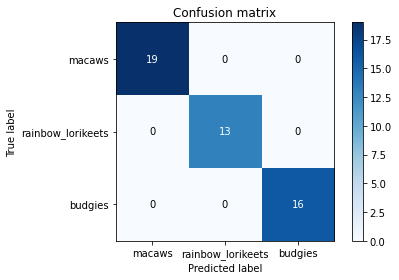

In [21]:

class_names = search_categories
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names,
       yticklabels=class_names,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

## Hopefully you have a unique image classifier !!